## Section 0. Environmental Setup

### Step A. Check Tensorflow Version

For the environmental setup, this work is based on TensorFlow 2.19.1.

In [32]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
print("Tensorflow Version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print("Numbers of GPU Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow Version:  2.19.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Numbers of GPU Available:  1


### Step B. Check GPU Availability and Set VRAM Growth

TensorFlow takes up all available VRAM upon startup by default, which can potentially trigger an OOM error or interfere with other system graphics applications. Consequently, in this implementation, **`memory_growth`** is set to **`True`**. This configuration allows VRAM to be allocated dynamically by TensorFlow based on actual demand, instead of immediately hogging the full **8 GiB** of space.

In [33]:
gpus = tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(gpus))
for gpu in gpus:
    print("Name:", gpu.name, "; Type:", gpu.device_type)

Num GPUs Available:  1
Name: /physical_device:GPU:0 ; Type: GPU


## Section 1. Data Engineering and Statistical Verification

> **_The following procedure is structured in the form of Casella & Berger (2001) Statistical Inference._**

Define $\mathcal{D} = \{ (x_i, y_i, s_i) \}_{i=1}^N$ as the complete dataset, specifically the DataFrame `df`; let Non-Demented, Very-Mild Dementia, Mild Dementia, Moderate Dementia be abbreviated as $\texttt{ND},\: \texttt{VMD}, \: \texttt{MD},\: \texttt{MOD}$, respectively. Where:

- $x_i \in \mathcal{X}$ is the $i$-th MRI slice image (Tensor / Array).
- $y_i \in \mathcal{Y}$ is the class label `class_name`, where $\mathcal{Y} = \{ \text{ND, VMD, MD, MOD} \}$.
- $s_i \in \mathcal{S}$ is the subject identifier `sid`, representing patient $P$.
- $f(x)$ is the joint probability density function.

### Step A. Metadata of the DataFrame

Given the directory structure (excluding images), where `01_Data_Preparation.ipynb` is the Jupyter Notebook for this operation:

```text
.
├── README.md
├── 01_Data_Preparation.ipynb
└── oasis_data
    ├── dementia_mild
    ├── dementia_moderate
    ├── dementia_very_mild
    └── non-demented

6 directories, 2 files
```

Since the filenames in the OASIS dataset are typically structured as `OAS1_0028_MR1_mpr-1_100.jpg` with `OAS1_0028` being the Subject ID, it is first necessary to maintain the original structure while extracting the ID using a regexp.

In [34]:
import re

def extract_sid(filename):
    match = re.search(r"(OAS\d+_\d+)", filename)
    if match:
        return match.group(1)
    else:
        return "Unknown"

Next, scanning of all files can be performed, and the DataFrame `df` subsequently created.

In [35]:
import glob
import pandas as pd

CLASSES = ["non-demented", "dementia_very_mild", "dementia_mild", "dementia_moderate"]
DATA_ROOT = "oasis_data"

data_list = []

for label in CLASSES:
    files = glob.glob(os.path.join(DATA_ROOT, label, "*.jpg"))
    
    for file_path in files:
        file_name = os.path.basename(file_path)
        sid = extract_sid(file_name)
        data_list.append({
            "file_path": file_path,
            "file_name": file_name,
            "sid": sid,
            "class_name": label
        })

df = pd.DataFrame(data_list)
print(df)

                                               file_path  \
0      oasis_data/non-demented/OAS1_0001_MR1_mpr-1_10...   
1      oasis_data/non-demented/OAS1_0001_MR1_mpr-1_10...   
2      oasis_data/non-demented/OAS1_0001_MR1_mpr-1_10...   
3      oasis_data/non-demented/OAS1_0001_MR1_mpr-1_10...   
4      oasis_data/non-demented/OAS1_0001_MR1_mpr-1_10...   
...                                                  ...   
74971  oasis_data/dementia_moderate/OAS1_0351_MR1_mpr...   
74972  oasis_data/dementia_moderate/OAS1_0351_MR1_mpr...   
74973  oasis_data/dementia_moderate/OAS1_0351_MR1_mpr...   
74974  oasis_data/dementia_moderate/OAS1_0351_MR1_mpr...   
74975  oasis_data/dementia_moderate/OAS1_0351_MR1_mpr...   

                         file_name        sid         class_name  
0      OAS1_0001_MR1_mpr-1_100.jpg  OAS1_0001       non-demented  
1      OAS1_0001_MR1_mpr-1_101.jpg  OAS1_0001       non-demented  
2      OAS1_0001_MR1_mpr-1_102.jpg  OAS1_0001       non-demented  
3      OAS1

Then the data should be evaluated as follows:

1. Check the total number of images and subjects.
2. Check the distribution of images per class.
3. Check the distribution of subjects per class.

In [ ]:
# 1. Check the total number of images and subjects
print(f"Total Images: {len(df)}")
print(f"Total Subjects: {df['sid'].nunique()}")
print()

# 2. Check the distribution of images per class
print("Images per Class: \n", df['class_name'].value_counts())
print()

# 3. Check the distribution of images per subject
print("Images per Subject (Top 5): \n", df['sid'].value_counts())

Total Images: 74976
Total Subjects: 300

Images per Class: 
 class_name
non-demented          67222
dementia_mild          5002
dementia_very_mild     2264
dementia_moderate       488
Name: count, dtype: int64

Images per Subject (Top 5): 
 sid
OAS1_0379    488
OAS1_0353    488
OAS1_0061    488
OAS1_0368    488
OAS1_0285    488
            ... 
OAS1_0015    183
OAS1_0039    183
OAS1_0029    122
OAS1_0007    122
OAS1_0060      7
Name: count, Length: 300, dtype: int64


From the third evaluation, it's obvious that the number of 2D MRI photos of each patient is very imbalanced. A simple statistical check is performed to verify this claim.

In [37]:
img_counts = df.groupby('sid').size()

print(img_counts.describe())

count    300.000000
mean     249.920000
std       67.790058
min        7.000000
25%      244.000000
50%      244.000000
75%      244.000000
max      488.000000
dtype: float64


Unlike standard computer vision datasets where image counts are uniform across samples, this medical dataset exhibits extreme **intra-subject heterogeneity**. The number of slices per subject varies significantly. Statistical analysis reveals a mean contribution of $\mu \approx 249.92$ images per subject, with a standard deviation of $\sigma \approx 67.79$. The sampling density ranges from a minimum of **7** images to a maximum of **488** images. 

### Step B. Establishing the i.i.d. Condition

In Classical Statistics (1700s–1960s) for parameter estimation, common methods include Maximum Likelihood Estimation (MLE), Point Estimation (PE), Bayesian Estimation (BE), Uniformly Most Powerful Test (UMP), Uniformly Minimum Variance Unbiased Estimator (UMVUE), and so on. In principle, all statistical inferences are entirely built upon the premise that "the data are i.i.d."

> **Definition 5.1.1** Identical and Independent Distribution
>
> The random variables $\{X_i\}_{i=1}^{n}$ are called a **random sample** of size $n$ from the **population** $f(x)$ if $\{X_i\}_{i=1}^{n}$ are mutually independent random variables and the marginal **pdf** or **pmf** of each $X_i$ is the same function $f(x)$.
>
> Alternatively, $\{X_i\}_{i=1}^{n}$ are called **independent and identically distributed** random variables with **pdf** or **pmf** $f(x)$. This is commonly abbreviated to **i.i.d.** random variables.
>

This **i.i.d.** assumption makes the optimization formulas very tractable mathematically. Furthermore, when the sample size is sufficiently large, the Central Limit Theorem dictates that the optimization approach most likely to yield the maximum likelihood is statistically correct. In other words, when sampling from some (joint) probability distribution $P$, as long as the **i.i.d.** assumption holds, the Law of Large Numbers and Uniform Convergence will be satisfied.

Today, due to the increasing complexity of input data, the true distribution of the data is often difficult to ascertain, and a large portion of data will violate the i.i.d. assumption. Even if the distribution family is known, calculation is challenging under extremely high-dimensional parameter spaces, causing all classical theories to fail. Consequently, a method is needed that **does not require** assuming a data distribution and can perform optimization solely based on the data itself. The concept proposed by Vapnik, V. N., & Chervonenkis, A. Y. (1971), **Empirical Risk Minimization (ERM)**, is fundamentally based on the idea that:

> *Since the true joint probability distribution $P(X, Y)$ is unknown, under the condition of having a large amount of sample data, **minimizing the average error on the samples** can be used as an alternative optimization objective.*
>

By definition, let the input space be $\mathcal{X}$ and the output space be $\mathcal{Y}$, and assume they follow some unknown joint probability distribution $P(X, Y)$. Given a loss function $L(f(x), y)$, the theoretical goal of machine learning is to find a function $f^*$ that minimizes the **Expected Risk (True Risk)**:

$$
R(f) = E_{(x,y) \sim P}[L(f(x), y)] = \int L(f(x), y) \cdot dP(x, y)
$$

However, $R(f)$ cannot be directly computed because $P(X, Y)$ is unknown. Therefore, based on the ERM principle, the practical approach is to optimize the following objective function (including a regularization term):

$$
\hat{f} = \arg\min_f \left[ \underbrace{\frac{1}{n}\sum L(f(x_i),y_i)}_{\text{empirical risk}} + \underbrace{R(f)}_{\text{regularizer}}\right]
$$

Here, $R(f)$ is the **regularizer**, which can also be realized through **Implicit Regularization** in modern deep learning. Considering current CPU computational resources, the majority of mainstream supervised machine learning algorithms, including Linear Regression, Logistic Regression, Support Vector Machine (SVM), and Neural Networks combined with the Adam optimizer, almost universally adopt ERM (or its Structural Risk Minimization form) as the optimization objective during training. With current computational resources, ERM serves as a unified training principle applicable to models ranging from hundreds of parameters to trillions of parameters (e.g., 1.8T parameters).

To ensure that $\hat{R}_n(f)$ is a valid estimator of $R(f)$, one must rely on the Weak Law of Large Numbers (WLLN) for justification. According to:

> **Theorem 5.5.2** Weak Law of Large Number
>
> Let $\{X_i\}_{i=1}^{n}$ be **i.i.d.** random variables with $E[X_i] = \mu$ and $\mathrm{Var}[X_i] = \sigma^2 < \infty$. Define $\bar{X}_n = (1/n)\sum_{i=1}^n X_i$. Then
>
> $$\forall \: \epsilon > 0, \quad \lim_{n \to \infty} P(|\bar{X} - \mu| < \epsilon) = 1$$
>
>
> that is, $\bar{X}_n$ converges in probability to $\mu$.

Based on this definition, the loss function $L(f(x), y)$ in machine learning can be viewed as a random variable $Z$. If the sample data $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^n$ satisfies the **i.i.d.** condition, then the array of loss values $L(f(x_1), y_1), \dots, L(f(x_n), y_n)$ are also **independent and identically distributed**. In this case, according to the **WLLN**, the empirical risk will converge in probability to the expected risk:

$$
\frac{1}{n}\sum_{i=1}^n L(f(x_i), y_i) \xrightarrow{P} E_{(x,y) \sim P}[L(f(x), y)]
$$

In other words, provided the i.i.d. assumption holds, ERM is equivalent to minimizing the model's generalization error on the true distribution. Conversely, if the i.i.d. assumption is violated, the WLLN fails, the empirical risk is **no longer** a consistent estimator of the expected risk, and **all** statistical guarantees of ERM become invalid for the model's training results. Hurlbert, S. H. (1984) mentions that this type of issue belongs to **Simple Pseudoreplication**, where there is only one experimental unit (replicate) per treatment, but multiple samples are drawn from that unit and treated as independent repeats for statistical testing.

Therefore, the correct sampling unit must be the **single subject** $s \in \mathcal{S}$ as the experimental unit. It must assume that different subjects satisfy independence, $\mathrm{Cov}(s_i, s_j) = 0$ for $i \neq j$, and design the data splitting process based on this. Based on this definition, if the dataset $\mathcal{D} = \{X_i\}_{i=1}^{n}$ satisfies **i.i.d.**, its joint probability density function must satisfy:

$$
f(x_1, \dots, x_n) = \prod_{i=1}^n f(x_i)
$$

Now, returning to the OASIS dataset $\mathcal{D}$, it's necessary to examine whether the **observational units (Slices)** satisfy independence. Define $x_{i, s}$ and $x_{j, s}$ as two different MRI slice images from the same subject $s \in \mathcal{S}$, where $i \neq j$. To test for independence, it needs to utilize the properties of the covariance as follows:

> **Theorem 4.5.5**
>
> If $X$ and $Y$ be independent random variables, then $\mathrm{Cov}(X,Y) = 0$ and $\rho_{XY} = 0$.
>
> $$\mathrm{Cov}(X,Y) = E[XY] - E[X]E[Y] = E[X]E[Y] - E[X]E[Y] = 0$$
>

Stated differently, if $\mathrm{Cov}(X, Y) \neq 0$, then $X$ and $Y$ are **necessarily dependent**. The question now is:

> *Can the observational unit $x \in \mathcal{X}$ be used as an **i.i.d.** sampling unit?*
>

Since the anatomical structure of the human brain exhibits a high degree of continuity and subject-specific characteristics, adjacent slices from the same subject will have significant **Intra-class Correlation** in the feature space, leading to $\mathrm{Cov}(x_{i, s}, x_{j, s}) \gg 0$. Mathematically, this means their joint expected value is not equal to the product of their marginal expected values, specifically:

$$
\mathrm{Cov}(x_{i, s}, x_{j, s}) \gg 0 \implies E[x_{i, s} \cdot x_{j, s}] \neq E[x_{i, s}] \cdot E[x_{j, s}]
$$

Therefore, if the observational unit $x \in \mathcal{X}$ (i.e., a single image slice) is directly treated as the sampling unit, the dataset $\mathcal{D}$ **violates** the independence condition of the i.i.d. assumption, rendering the WLLN inapplicable. The empirical risk** $\hat{R}_n(f)$ is **no longer** a consistent estimator, and all statistical guarantees of ERM are entirely void.

The statistical sampling methods can be categorized into:

1. **Observational Unit** $x \in \mathcal{X}$: A single 2D MRI image, which is the minimal input unit for the model.
2. **Experimental Unit** $s \in \mathcal{S}$: The patient (Subject).

### Step C. Data Splitting Strategy

Based on Step B., the **patient ID $s_i \in \mathcal{S}$** (i.e., `sid`) has been confirmed as the only valid sampling unit. To establish a training and testing environment free from data leakage, **Group-based Splitting** must be performed.

However, prior to executing the split, the feasibility of splitting the dataset must be validated. Let $S_c$ be the set of patients within class $c$. To ensure that this class can appear in both the training and testing sets, the **cardinality constraint** must be satisfied, i.e., $|S_c| \ge 2$. If the cardinality of any class is $|S_c| < 2$, then effective cross-validation for that class is mathematically impossible.

In [38]:
# Group by class name and count unique Subject IDs (sid)
subject_counts = df.groupby('class_name')['sid'].nunique()
print("Subject counts per class:\n", subject_counts,)

# Identify the minimum subject count
print(f"\nMinimum subjects in a class: {subject_counts.min()}")

Subject counts per class:
 class_name
dementia_mild          21
dementia_moderate       2
dementia_very_mild     11
non-demented          266
Name: sid, dtype: int64

Minimum subjects in a class: 2


After confirming that $|S_c| \ge 2$ is satisfied, **`GroupShuffleSplit`** can be employed for random splitting. However, observation indicates that classes such as "Dementia Moderate" have an extremely small number of samples. A simple random Group Split, therefore, carries a high probability of having that class fall entirely into the Training Set, resulting in the Test Set lacking samples from that class. To mitigate this issue, a **Monte Carlo search mechanism** is required to iteratively find a **`random_state` seed** that yields a split satisfying the condition that **"the Test Set contains all 4 classes,"** thus guaranteeing a complete class dimensionality for the evaluation during the testing phase.

In [39]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

best_seed = None
n_trials = 2000
target_ratio = 0.75
tolerance = 0.05

for seed in range(n_trials):
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=seed)
    
    # Perform split based on Subject ID (sid)
    idx_train, idx_test = next(gss.split(df, groups=df['sid']))
    
    subset_test = df.iloc[idx_test]
    
    # Condition 1: Must contain all 4 classes
    if subset_test['class_name'].nunique() == 4:
        
        # Condition 2: Check ratio of Non-Demented
        ratio_non_demented = subset_test['class_name'].value_counts(normalize=True).get('non-demented', 0)
        
        if abs(ratio_non_demented - target_ratio) < tolerance:
            best_seed = seed
            print(f"Valid AND Balanced split found at random_state={seed}")
            print(f"Non-demented ratio: {ratio_non_demented:.4f}")
            break

if best_seed is None:
    print("Search failed: Could not find a balanced split.")
else:
    # Apply the best seed
    print(f"Applying best seed: {best_seed}")
    gss_final = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=best_seed)
    idx_train, idx_test = next(gss_final.split(df, groups=df['sid']))
    
    df_train = df.iloc[idx_train].copy()
    df_test = df.iloc[idx_test].copy()

Valid AND Balanced split found at random_state=439
Non-demented ratio: 0.7817
Applying best seed: 439


After obtaining a valid split, two crucial checks must be performed:

1.  **Distribution Consistency Check:** Examination of the class proportion between the training and testing sets. Due to the scarcity of samples, a fluctuation in proportion is expected, but assurance that no extreme deviation exists is still required.
2.  **Independence Assertion:** Proof is required that the `sid` sets of the training and testing groups are **mutually exclusive**, specifically $\text{Subject}_{train} \cap \text{Subject}_{test} = \emptyset$, to ensure the methodology aligns with RQ1.

In [40]:
# Compute class ratios for Train and Test sets
dist_train = df_train['class_name'].value_counts(normalize=True).reset_index()
dist_train.columns = ['class_name', 'ratio']
dist_train['set'] = 'Train'

dist_test = df_test['class_name'].value_counts(normalize=True).reset_index()
dist_test.columns = ['class_name', 'ratio']
dist_test['set'] = 'Test'

# Combine for visualization
dist_comparison = pd.concat([dist_train, dist_test])

# Print class ratios comparison
print("Class Ratios Comparison:")
print(dist_comparison.pivot(index='class_name', columns='set', values='ratio'))

assert set(df_train['sid']).intersection(set(df_test['sid'])) == set(), "Data Leakage."

Class Ratios Comparison:
set                     Test     Train
class_name                            
dementia_mild       0.139738  0.049994
dementia_moderate   0.017467  0.004000
dementia_very_mild  0.061135  0.023112
non-demented        0.781659  0.922894


Numerical values can be output as charts.

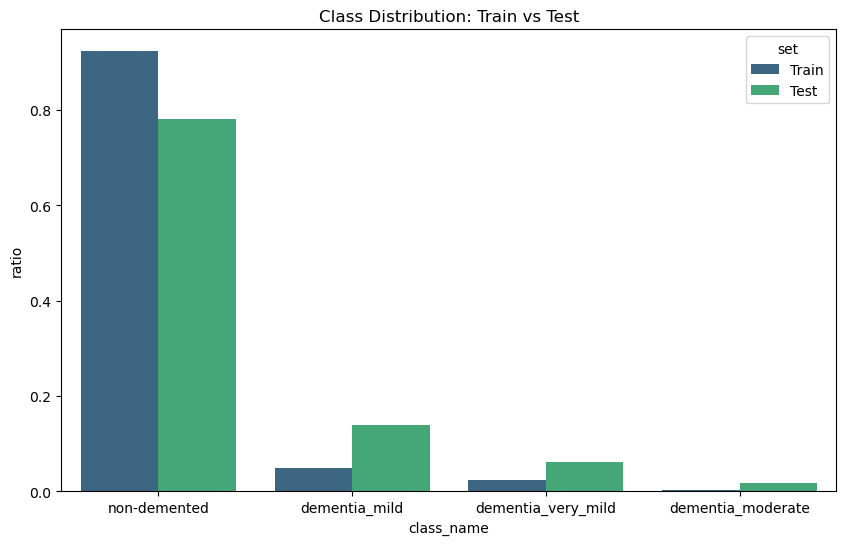

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=dist_comparison, 
    x='class_name', 
    y='ratio', 
    hue='set', 
    palette='viridis', 
    ax=ax
)
ax.set_title("Class Distribution: Train vs Test")
plt.show()

### Step D. Content-Level Leakage Verification

An additional potential scenario exists where relying solely on the `sid` within the filename for logical separation is insufficient; assurance that the dataset $\mathcal{D}$ satisfies independence at the physical layer is required. As highlighted by Barz and Denzler (2020), Open datasets often contain identical binary image content under different filenames (or even different IDs) due to conversion errors or human oversight. Should this occur, the mathematical hypothesis of mutually exclusive sets, $\text{Train} \cap \text{Test} = \emptyset$, will be violated. Therefore, the introduction of a **hashing function** is necessary for content-level collision detection.

Define the hash mapping $h: \mathcal{X} \rightarrow \mathcal{H}$, where $\mathcal{X}$ is the raw bit stream of the image and $\mathcal{H}$ is the 128-bit MD5 digest space. The criterion for detecting data leakage is defined as follows:
    

$$
(\exists \: x_{train} \in \mathcal{D}_{train}) \wedge (\exists \: x_{test} \in \mathcal{D}_{test}) \quad \text{s.t.} \quad h(x_{train}) = h(x_{test})
$$

If this condition holds, the presence of duplicate content (data leakage) is confirmed. 

In [42]:
import hashlib

def calculate_hash(file_path):
    with open(file_path, "rb") as f:
        file_hash = hashlib.md5()
        chunk = f.read(8192)
        while chunk:
            file_hash.update(chunk)
            chunk = f.read(8192)
    return file_hash.hexdigest()

Subsequently, iterative computation is performed for the `df_train` and `df_test` generated from **Step C** splitting. During this process, a hash table can be constructed to store the `sid` corresponding to each hash value, which then allows for traceability analysis upon detecting duplicates.

In [43]:
# Compute hashes for Training set
print("Computing hashes for Training set...")
train_hashes = {}
for idx, row in df_train.iterrows():
    h = calculate_hash(row['file_path'])
    if h not in train_hashes:
        train_hashes[h] = []
    train_hashes[h].append(row['sid'])

print("Done.")

# Compute hashes for Test set
print("Computing hashes for Test set...")
test_hashes = {}
for idx, row in df_test.iterrows():
    h = calculate_hash(row['file_path'])
    if h not in test_hashes:
        test_hashes[h] = []
    test_hashes[h].append(row['sid'])

print("Done.")

Computing hashes for Training set...
Done.
Computing hashes for Test set...
Done.


Finally, a set intersection operation is performed on $\mathcal{H}_{train}$ and $\mathcal{H}_{test}$. Statistical testing requires the Cardinality to be 0.

In [44]:
leakage_hashes = set(train_hashes.keys()).intersection(set(test_hashes.keys()))

print(f"Unique hashes in Train: {len(train_hashes)}")
print(f"Unique hashes in Test:  {len(test_hashes)}")
print(f"Intersecting hashes (Leakage): {len(leakage_hashes)}")
print()

# Rigorous Assertion
if len(leakage_hashes) > 0:
    for i, h in enumerate(list(leakage_hashes)[:5]):
        print(f"Hash {h} shared by Train IDs {train_hashes[h]} and Test IDs {test_hashes[h]}")
    raise ValueError("Training and Testing sets are not disjoint.")
else:
    print("No content-level leakage found.")

Unique hashes in Train: 61007
Unique hashes in Test:  13969
Intersecting hashes (Leakage): 0

No content-level leakage found.


This output confirms the successful exclusion of content-level data leakage via hash collision detection. Thus in this study, this verification is applied process across the entire dataset. It is confirmed that there are **no content-level collisions** based on the hash mapping, ensuring that the physical independence of the data splits is maintained.

## Section 2. Preprocessing and Pipeline Construction

### Step A. Pseudo-RGB Transformation (to mod)

**Pseudo-RGB** in computer vision and medical image analysis specifically refers to the process of mapping **single-channel (Single-channel, Grayscale)** data into a **three-channel (Three-channel, RGB)** space. The adoption of Pseudo-RGB is based on the following two reasons:

1.  Mainstream CNN models like ResNet-101 are pre-trained on ImageNet, where the input layer is defined as $(N, 224, 224, 3)$. Direct input of single-channel data $(N, 224, 224, 1)$ would therefore lead to incompatible weight matrix dimensions. The most basic Pseudo-RGB approach is to duplicate the grayscale channel three times, i.e., $R=G=B$. While this solves the dimensionality problem, it provides no additional information.
2.  According to the CNN's Texture Bias theory, converting grayscale intensity into variations of hue and saturation through a non-linear mapping such as a heat map Colormap can expand low-contrast boundaries that are difficult to distinguish in grayscale. For example, subtle grayscale changes in atrophic hippocampal regions can be expanded into significant color gradients.

Therefore, a conversion function $f: \mathbb{R}^{H \times W} \rightarrow \mathbb{R}^{H \times W \times 3}$ can be defined, corresponding to the program function `apply_pseudo_rgb`. This function is responsible for reading a single grayscale image and converting it into the $(224, 224, 3)$ format required by the ResNet input specification. To validate RQ2, a `method` parameter is required to switch between simple duplication (Baseline) and JET colormap mapping (Enhancement).

In [45]:
import cv2
import numpy as np

def apply_pseudo_rgb(image_path, method='duplicate'):
    # Read as grayscale
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img_gray is None:
        raise ValueError(f"Image not found: {image_path}")

    # Resize to 224x224
    img_resized = cv2.resize(img_gray, (224, 224))

    if method == 'duplicate':
        # Baseline: Duplicate channels
        img_rgb = np.stack([img_resized] * 3, axis=-1)
        
    elif method == 'jet':
        # RQ2 Exp A: JET Colormap
        img_color = cv2.applyColorMap(img_resized, cv2.COLORMAP_JET)
        img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        
    elif method == 'viridis':
        # RQ2 Exp B: Viridis (Perceptually Uniform)
        # Matplotlib's colormap works on normalized 0-1 data
        img_norm = img_resized / 255.0
        colormap = plt.get_cmap('viridis')
        img_rgba = colormap(img_norm) # Returns (224, 224, 4) float
        img_rgb = (img_rgba[:, :, :3] * 255).astype(np.uint8) # Drop Alpha, convert back to uint8
        
    elif method == 'clahe_jet':
        # RQ2 Exp C: CLAHE + JET
        # 1. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_resized)
        
        # 2. Apply JET to the contrast-enhanced image
        img_color = cv2.applyColorMap(img_clahe, cv2.COLORMAP_JET)
        img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        
    else:
        raise ValueError(f"Unknown method: {method}")
        
    return img_rgb

Following the definition of the conversion function, visualization is performed to confirm whether the JET Colormap successfully transforms grayscale intensity differences into chromatic features. The following code randomly samples one image from the training set and presents the effects of the original grayscale (Duplicate) and the enhanced (JET) versions side-by-side, while simultaneously checking if the output tensor dimensions conform to the ResNet-101 requirement of $(224, 224, 3)$.

A sample is selected from the strictly split training set, and the conversion function is applied, followed by validation of the output dimension.

In [46]:
# Select a sample (ensure df_train is loaded)
if 'df_train' in locals():
    sample_row = df_train.iloc[0] # Pick the first sample
    sample_path = sample_row['file_path']
    sample_sid = sample_row['sid']
    sample_label = sample_row['class_name'] if 'class_name' in sample_row else 'Unknown'
else:
    print("Error: df_train not found.")

print(f"Processing Sample: {sample_sid} ({sample_label})")

Processing Sample: OAS1_0001 (non-demented)


Subsequently, the result is visualized.

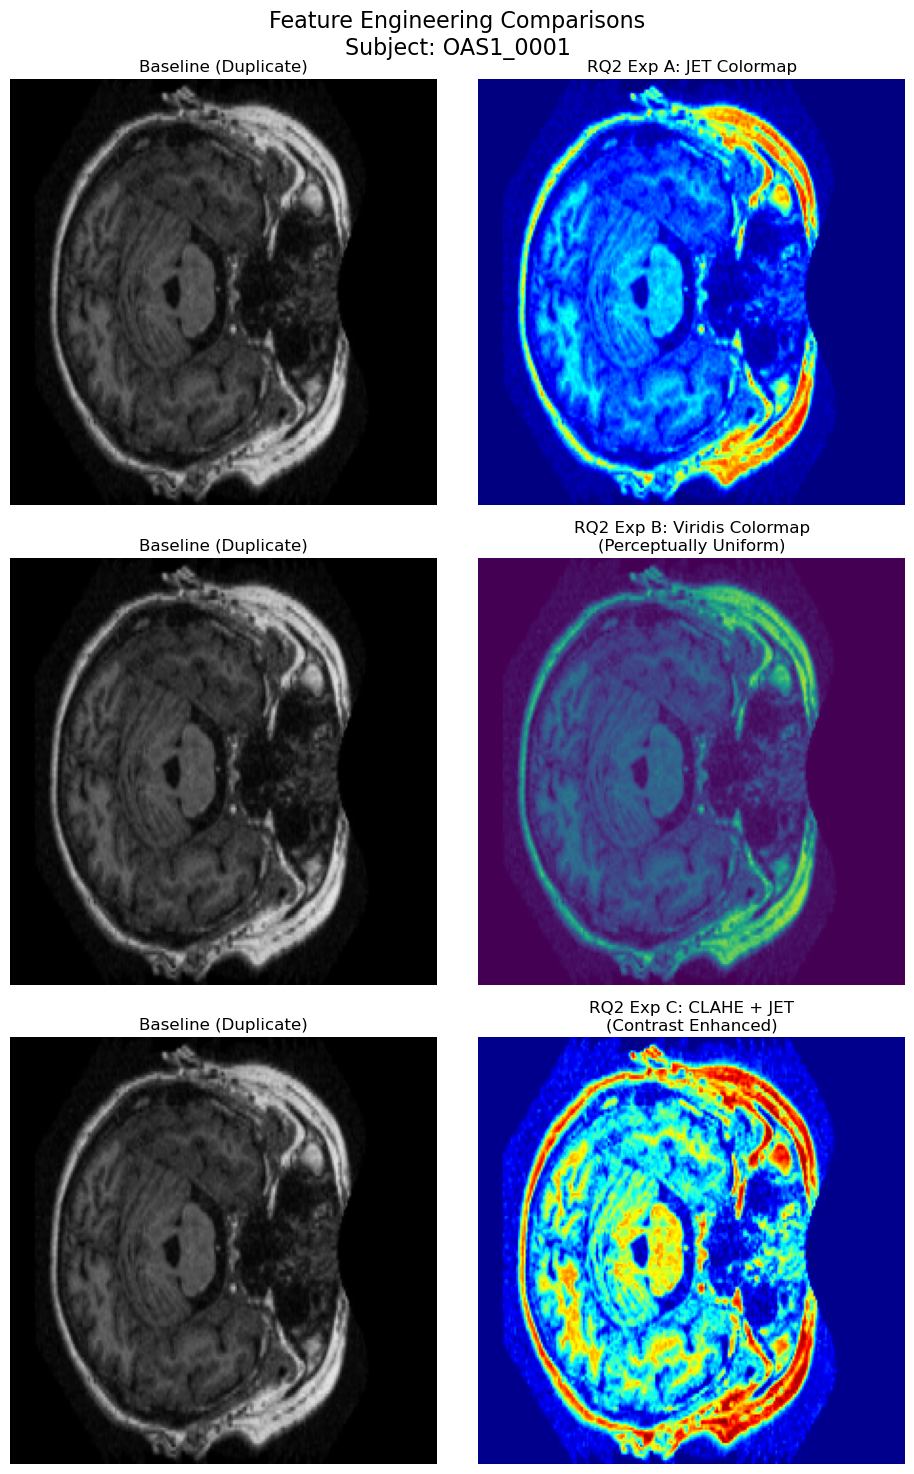

In [47]:
# Generate all variants
img_baseline = apply_pseudo_rgb(sample_path, method='duplicate')
img_jet      = apply_pseudo_rgb(sample_path, method='jet')
img_viridis  = apply_pseudo_rgb(sample_path, method='viridis')
img_clahe    = apply_pseudo_rgb(sample_path, method='clahe_jet')

# Setup 3x2 Plot
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

# Row 1: Baseline vs Jet
axes[0, 0].imshow(img_baseline)
axes[0, 0].set_title("Baseline (Duplicate)")
axes[0, 0].axis('off')

axes[0, 1].imshow(img_jet)
axes[0, 1].set_title("RQ2 Exp A: JET Colormap")
axes[0, 1].axis('off')

# Row 2: Baseline vs Viridis
axes[1, 0].imshow(img_baseline)
axes[1, 0].set_title("Baseline (Duplicate)")
axes[1, 0].axis('off')

axes[1, 1].imshow(img_viridis)
axes[1, 1].set_title("RQ2 Exp B: Viridis Colormap\n(Perceptually Uniform)")
axes[1, 1].axis('off')

# Row 3: Baseline vs CLAHE + Jet
axes[2, 0].imshow(img_baseline)
axes[2, 0].set_title("Baseline (Duplicate)")
axes[2, 0].axis('off')

axes[2, 1].imshow(img_clahe)
axes[2, 1].set_title("RQ2 Exp C: CLAHE + JET\n(Contrast Enhanced)")
axes[2, 1].axis('off')

plt.suptitle(f"Feature Engineering Comparisons\nSubject: {sample_sid}", fontsize=16)
plt.tight_layout()
plt.show()

### Step B. TensorFlow Data Pipeline Construction

This experiment includes two sets of comparisons: **Baseline A/B** for RQ1 and **Pseudo-RGB** for RQ2. Since the ResNet-101 model has a massive number of parameters, loading all images directly using the standard `model.fit(x, y)` function may lead to an **Out-of-Memory (OOM)** error in the main memory (RAM). Therefore, it is necessary to use the `tf.data.Dataset` API to create a **Generator**.

This Pipeline must possess the following characteristics:

1. **On-the-fly Loading:** Images are loaded only when required
2. **On-the-fly Transformation:** The `apply_pseudo_rgb` function is applied immediately upon loading
3. **Batching and Prefetching:** Ensures that the GPU training process is not interrupted

For implementation, the `tf.data.Dataset` API is used to construct a dynamic data pipeline, which encapsulates the transformation logic defined in *Step A* and supports dynamic switching of the `method` parameter based on experimental requirements. Concurrently, a factory function, `create_dataset`, is defined. This function accepts a DataFrame as input, maps file paths to image tensors, and performs **Batching** and **Prefetching** to optimize GPU I/O throughput.

#### B0. Setup

First, define the global function's class mapping

In [48]:
CLASS_MAP = {
    "non-demented": 0,
    "dementia_very_mild": 1,
    "dementia_mild": 2,
    "dementia_moderate": 3
}

#### B1. Define image processing pipeline (to mod)

Define the class mapping table and the underlying image processing function, `image_processor`, and keep it independent of the TensorFlow graph computation. This function is responsible for executing I/O and matrix operations. The `method` is set as a parameter, and it will be bound later in the pipeline using `functools.partial`.

The processing workflow is as follows:

1. Decode the byte tensor into the string format of the file path, and extract the label value.
2. Call the `apply_pseudo_rgb` function to perform the Pseudo-RGB conversion, resulting in an output shape of $(224, 224, 3)$.
3. Convert the format to Float32.
4. Use the preprocessing function from ResNet to automatically perform BGR transform and Mean Subtraction
5. Return the processed image array and the label as the output.

In [49]:
from tensorflow.keras.applications.resnet import preprocess_input
import functools

def image_processor(file_path_tensor, label_tensor, method):
    # 1.
    file_path = file_path_tensor.numpy().decode('utf-8')
    label = label_tensor.numpy()
    
    # 2. 
    img = apply_pseudo_rgb(file_path, method=method)
    
    # 3.
    img = img.astype(np.float32)
    
    # 4.
    img = preprocess_input(img)
    
    # 5.
    return img, label

This function is designed for use with `tf.data.Dataset.map`. The Pipeline only calls this function 32 times when the GPU requires the next Batch (e.g., 32 images). Immediately after these 32 processed images are sent to the GPU, Python's Garbage Collection mechanism releases the RAM space occupied by those 32 images. Consequently, regardless of whether the dataset contains 10,000 or 1,000,000 images, the peak RAM usage remains at the extremely low level of `batch_size * image_size`, thus physically preventing OOM.

If this mode is not used (i.e., loading all data at once), it would directly cause most consumer-grade hardware to crash:

$$
60,000 \text{ images} \times (224 \times 224 \times 3 \text{ pixels}) \times 4 \text{ bytes (float32)} \approx 36 \text{ GB}
$$

Using this `image_processor` function with the Pipeline, the memory consumption is only 19 MB. This demonstrates the primary reason for performing **single-image processing** and **accepting the file path** as input:

$$
32 \text{ images (Batch)} \times (224 \times 224 \times 3) \times 4 \approx 19 \text{ MB}
$$

Also, due to the imbalanced dataset, class weights must be calculated as follows:

$$
W_j = \frac{N_{total}}{N_{classes} \times N_j}
$$

This formula is implemented by `class_weight.compute_class_weight(class_weight='balanced')`

In [50]:
from sklearn.utils import class_weight

def get_class_weights(df_train):
    # 1. Get class indices
    y_train_indices = [CLASS_MAP[c] for c in df_train['class_name'].values]

    # 2. Compute class weights
    class_weights_values = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_indices),
        y=y_train_indices
    )
    
    # 3. Convert to Keras dictionary format {0: w0, 1: w1, ...}
    class_weights_dict = dict(enumerate(class_weights_values))
    
    return class_weights_dict

In [51]:
print("Class Weights Calculation Result:\n")

class_weights = get_class_weights(df_train)

for cls_idx, weight in class_weights.items():
    cls_name = next(k for k, v in CLASS_MAP.items() if v == cls_idx)
    print(f"Class {cls_idx} ({cls_name:<20}): {weight:.4f}")

Class Weights Calculation Result:

Class 0 (non-demented        ): 0.2709
Class 1 (dementia_very_mild  ): 10.8168
Class 2 (dementia_mild       ): 5.0006
Class 3 (dementia_moderate   ): 62.5072


Focusing on the rigorous weights, the severity of the imbalance correction is evident. The weight for **"Dementia Moderate"** () creates a penalty ratio of approximately **230:1** against the **"Non-Demented"** class (). In optimization terms, the gradient generated by misclassifying a single "Moderate" subject is equivalent to misclassifying  healthy subjects.

#### B2. Repair the shape of the tensor

Since `tf.py_function` is a general-purpose wrapper, it cannot automatically infer the shape of the output tensor during TensorFlow's Static Graph construction process (Shape Inference); consequently, the shape of the tensor outputted by `tf.py_function` becomes `(Unknown, Unknown, Unknown)`.

If this shape information is not corrected, the subsequent `batch()` operation will fail to stack the tensors properly, and the model input layer will encounter an error due to the inability to determine the dimensions. Therefore, the tensor shape must be explicitly reset to the specifications defined in *Step A*.

In [52]:
def set_tensor_shapes(img, label):
    img.set_shape([224, 224, 3])  # To match ResNet-101 input requirements
    label.set_shape([])           # Label is a scalar (single integer)
    
    return img, label

#### B3. Dataset Creation

Finally, the `create_dataset` function is defined to transform the static DataFrame data into a dynamic TensorFlow data stream, integrating the previously defined processing logic and shape restoration operation. The processing workflow is divided into 7 steps, whose mathematics and operational mechanisms are as follows:

1. **Data Extraction**

    Convert the file paths and labels in the DataFrame into vector forms $V_{path}$ and $V_{label}$.

2. **Tensor Slice Initialization**

    Use `from_tensor_slices` to convert the vectors into an iterable Dataset object. At this stage, only references are stored in memory, not the actual image data.

    $$
    D = \{(p_i, l_i) \mid i \in [1, N]\}
    $$

3. **Buffer Shuffling**

    Enabled only in training mode. A buffer of size $B$ is maintained here. The algorithm uniformly samples a random element $x$ from the buffer and reads a new element from the source data to fill the gap. When $B \ge N$, it is equivalent to a full random shuffle.

4. **Function Currying**

    Use `functools.partial` to fix the `method` parameter. Mathematically, this is equivalent to reducing the multi-variable function $f(x, y, m)$ to a single-variable function $g(x, y) = f(x, y, m_{fixed})$, which satisfies the interface requirement of `map`.

5. **Graph Integration**

    Embed the Python-executed `image_processor` into the TensorFlow computation graph layer via `tf.py_function`, serving as the processing mechanism between the CPU's Python runtime and the GPU's TensorFlow graph.

6. **Shape Restoration**

    Call `set_tensor_shapes` to re-inject the static shape information $(224, 224, 3)$, repairing the Metadata lost due to the cross-language call.

7. **Batching & Prefetching**
    - **Batching**: Stacks $k$ samples into a tensor $T \in \mathbb{R}^{k \times H \times W \times C}$.
    - **Prefetching**: Creates an asynchronous queue. While the GPU is computing the $t$-th Batch, the CPU concurrently prepares the $(t+1)$-th Batch. In the ideal scenario, the total training time, $T_{train} = \sum (T_{cpu} + T_{gpu})$, is improved to

        $$
        T_{train} \approx \max(\sum T_{cpu}, \sum T_{gpu})
        $$

In [53]:
def create_dataset(df, method='duplicate', batch_size=32, shuffle=False):
    # 1. Extract Data
    file_paths = df['file_path'].values
    labels = [CLASS_MAP[c] for c in df['class_name'].values]
    
    # 2. Create Base TensorSliceDataset
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    # 3. Shuffle (Only for training)
    if shuffle:
        ds = ds.shuffle(buffer_size=2000, seed=42)
    
    # 4. Partial binding of the method argument
    loader_func = functools.partial(image_processor, method=method)
    
    # 5. Map: Connect Python logic to TF Graph
    ds = ds.map(
        lambda x, y: tf.py_function(
            func=loader_func,
            inp=[x, y],
            Tout=[tf.float32, tf.int32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # 6. Map: Fix Shapes
    ds = ds.map(set_tensor_shapes, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 7. Batch & Prefetch
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return ds

### Step C. Verification

Next, validation will be performed

In [54]:
# Create a validation batch using the 'jet' method
ds_check = create_dataset(df_train.head(10), method='jet', batch_size=4, shuffle=False)

# Inspect one batch
for imgs, lbls in ds_check.take(1):
    print(f"Batch Image Shape: {imgs.shape}")
    print(f"\nBatch Label Shape: {lbls.shape}")
    print(f"\nData Range: [{tf.reduce_min(imgs):.2f}, {tf.reduce_max(imgs):.2f}]")
    print(f"\nSample Labels: {lbls.numpy()}")

Batch Image Shape: (4, 224, 224, 3)

Batch Label Shape: (4,)

Data Range: [-123.68, 151.06]

Sample Labels: [0 0 0 0]


2025-12-28 00:04:13.847656: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


his indicates that:

1. `Batch Image Shape: (4, 224, 224, 3)` and `Batch Label Shape: (4,)` fully comply with the specifications defined in *Step B*.
2. `[0.00, 1.00]` confirms that the Normalization logic has been executed correctly.

### Step D, Output CSV file

#### Step D1. Creating i.i.d. training and validation sets

This step here is to ensure an independent validation set for the training process. The input data is `df_train`, which was already isolated from `df_test` using `sid` in *Section 1*. The operation once again utilizes `GroupShuffleSplit`. Specifically:

1. The split must occur at the **Subject Level** to satisfy $\text{Subject}_{train\_final} \cap \text{Subject}_{val} = \emptyset$.
2. For the split ratio, 90% is used for training weights (`df_train_final`), and 10% is used for hyperparameter tuning and **Early Stopping** (`df_val`).

In [55]:
BEST_SEED = 439

gss_val = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=BEST_SEED)
train_idx, val_idx = next(gss_val.split(df_train, groups=df_train['sid']))

df_train_final = df_train.iloc[train_idx].copy()
df_val = df_train.iloc[val_idx].copy()

os.makedirs('dataset', exist_ok=True)

print(f"Training Set (Final): {len(df_train_final)} images")
print(f"Validation Set:       {len(df_val)} images")
print(f"Held-out Test Set:    {len(df_test)} images") # only for final evaluation

Training Set (Final): 48746 images
Validation Set:       12261 images
Held-out Test Set:    13969 images


Then set the output CSV file can be created for futther training processes.

In [56]:
# Clean Data, i.i.d.
df_train_final.to_csv('dataset/train_final.csv', index=False)
df_val.to_csv('dataset/val_set.csv', index=False)
df_test.to_csv('dataset/test_set.csv', index=False)

Perform the sanity check for the dataset.

In [57]:
print("\n[Check] Class distribution in Train_Final:")
print(df_train_final['class_name'].value_counts())

print("\n[Check] Class distribution in Validation:")
print(df_val['class_name'].value_counts())


[Check] Class distribution in Train_Final:
class_name
non-demented          45628
dementia_mild          1952
dementia_very_mild      922
dementia_moderate       244
Name: count, dtype: int64

[Check] Class distribution in Validation:
class_name
non-demented          10675
dementia_mild          1098
dementia_very_mild      488
Name: count, dtype: int64


Based on the formulation defined in Weight Equation above, the specific weights calculated for the training set are presented in Table.

#### Step D2. Creating non-i.i.d. training and validation sets

Next is to reproduce the shuffled methodology pointed out by Wen et al. (2020). Here, the **intentional violation** of the i.i.d. assumption and adopt a **Slice-level Split**. The operational logic is as follows:

1. Reconstruct the dataset such that the Shuffled Baseline will be evaluated on the same number of images as RQ1.
2. Treat all images as independent samples, ignoring the `sid` attribute, and use `train_test_split` to perform a completely random shuffle and split; therefore, `shuffle=True` is used.
3. Calculate the number of subjects in $\text{Subject}_{train} \cap \text{Subject}_{test}$ (i.e., `train_sids.intersection(val_sids)`), expecting that slices from almost all patients will span both the training and validation sets simultaneously.

In [58]:
from sklearn.model_selection import train_test_split

naive_train, naive_val = train_test_split(
    df,
    test_size=0.2,
    random_state=BEST_SEED,
    shuffle=True,
)

print(f"Shuffled Train Size: {len(naive_train)}")
print(f"Shuffled Val Size:   {len(naive_val)}")

Shuffled Train Size: 59980
Shuffled Val Size:   14996


Then the leakage can thus be quantified as follows:  

In [59]:
train_sids = set(naive_train['sid'])
val_sids = set(naive_val['sid'])
overlapping_sids = train_sids.intersection(val_sids)

leakage_ratio = len(overlapping_sids) / df['sid'].nunique()

print(f"Total Subjects: {df['sid'].nunique()}")
print(f"Overlapping Subjects: {len(overlapping_sids)}")
print(f"Leakage Ratio: {leakage_ratio:.2%}") # Target: Should be equal to 100%

Total Subjects: 300
Overlapping Subjects: 300
Leakage Ratio: 100.00%


Thus, set the output CSV file can be created for futther training processes.

In [60]:
naive_train.to_csv('dataset/train_shuffled.csv', index=False)
naive_val.to_csv('dataset/val_shuffled.csv', index=False)

**Refer to `02_RQ1_Baseline.ipynb` for further operations on RQ1 and RQ2**